## Генерируем данные

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_moons

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
X, y = make_moons(n_samples=1_000, random_state=0, noise=0.3)

df = pd.DataFrame({
    'feat1': X[:, 0],
    'feat2': X[:, 1],
    'feat3': np.random.rand(X.shape[0]),
    'feat4': np.random.rand(X.shape[0]),
    'target': y
})

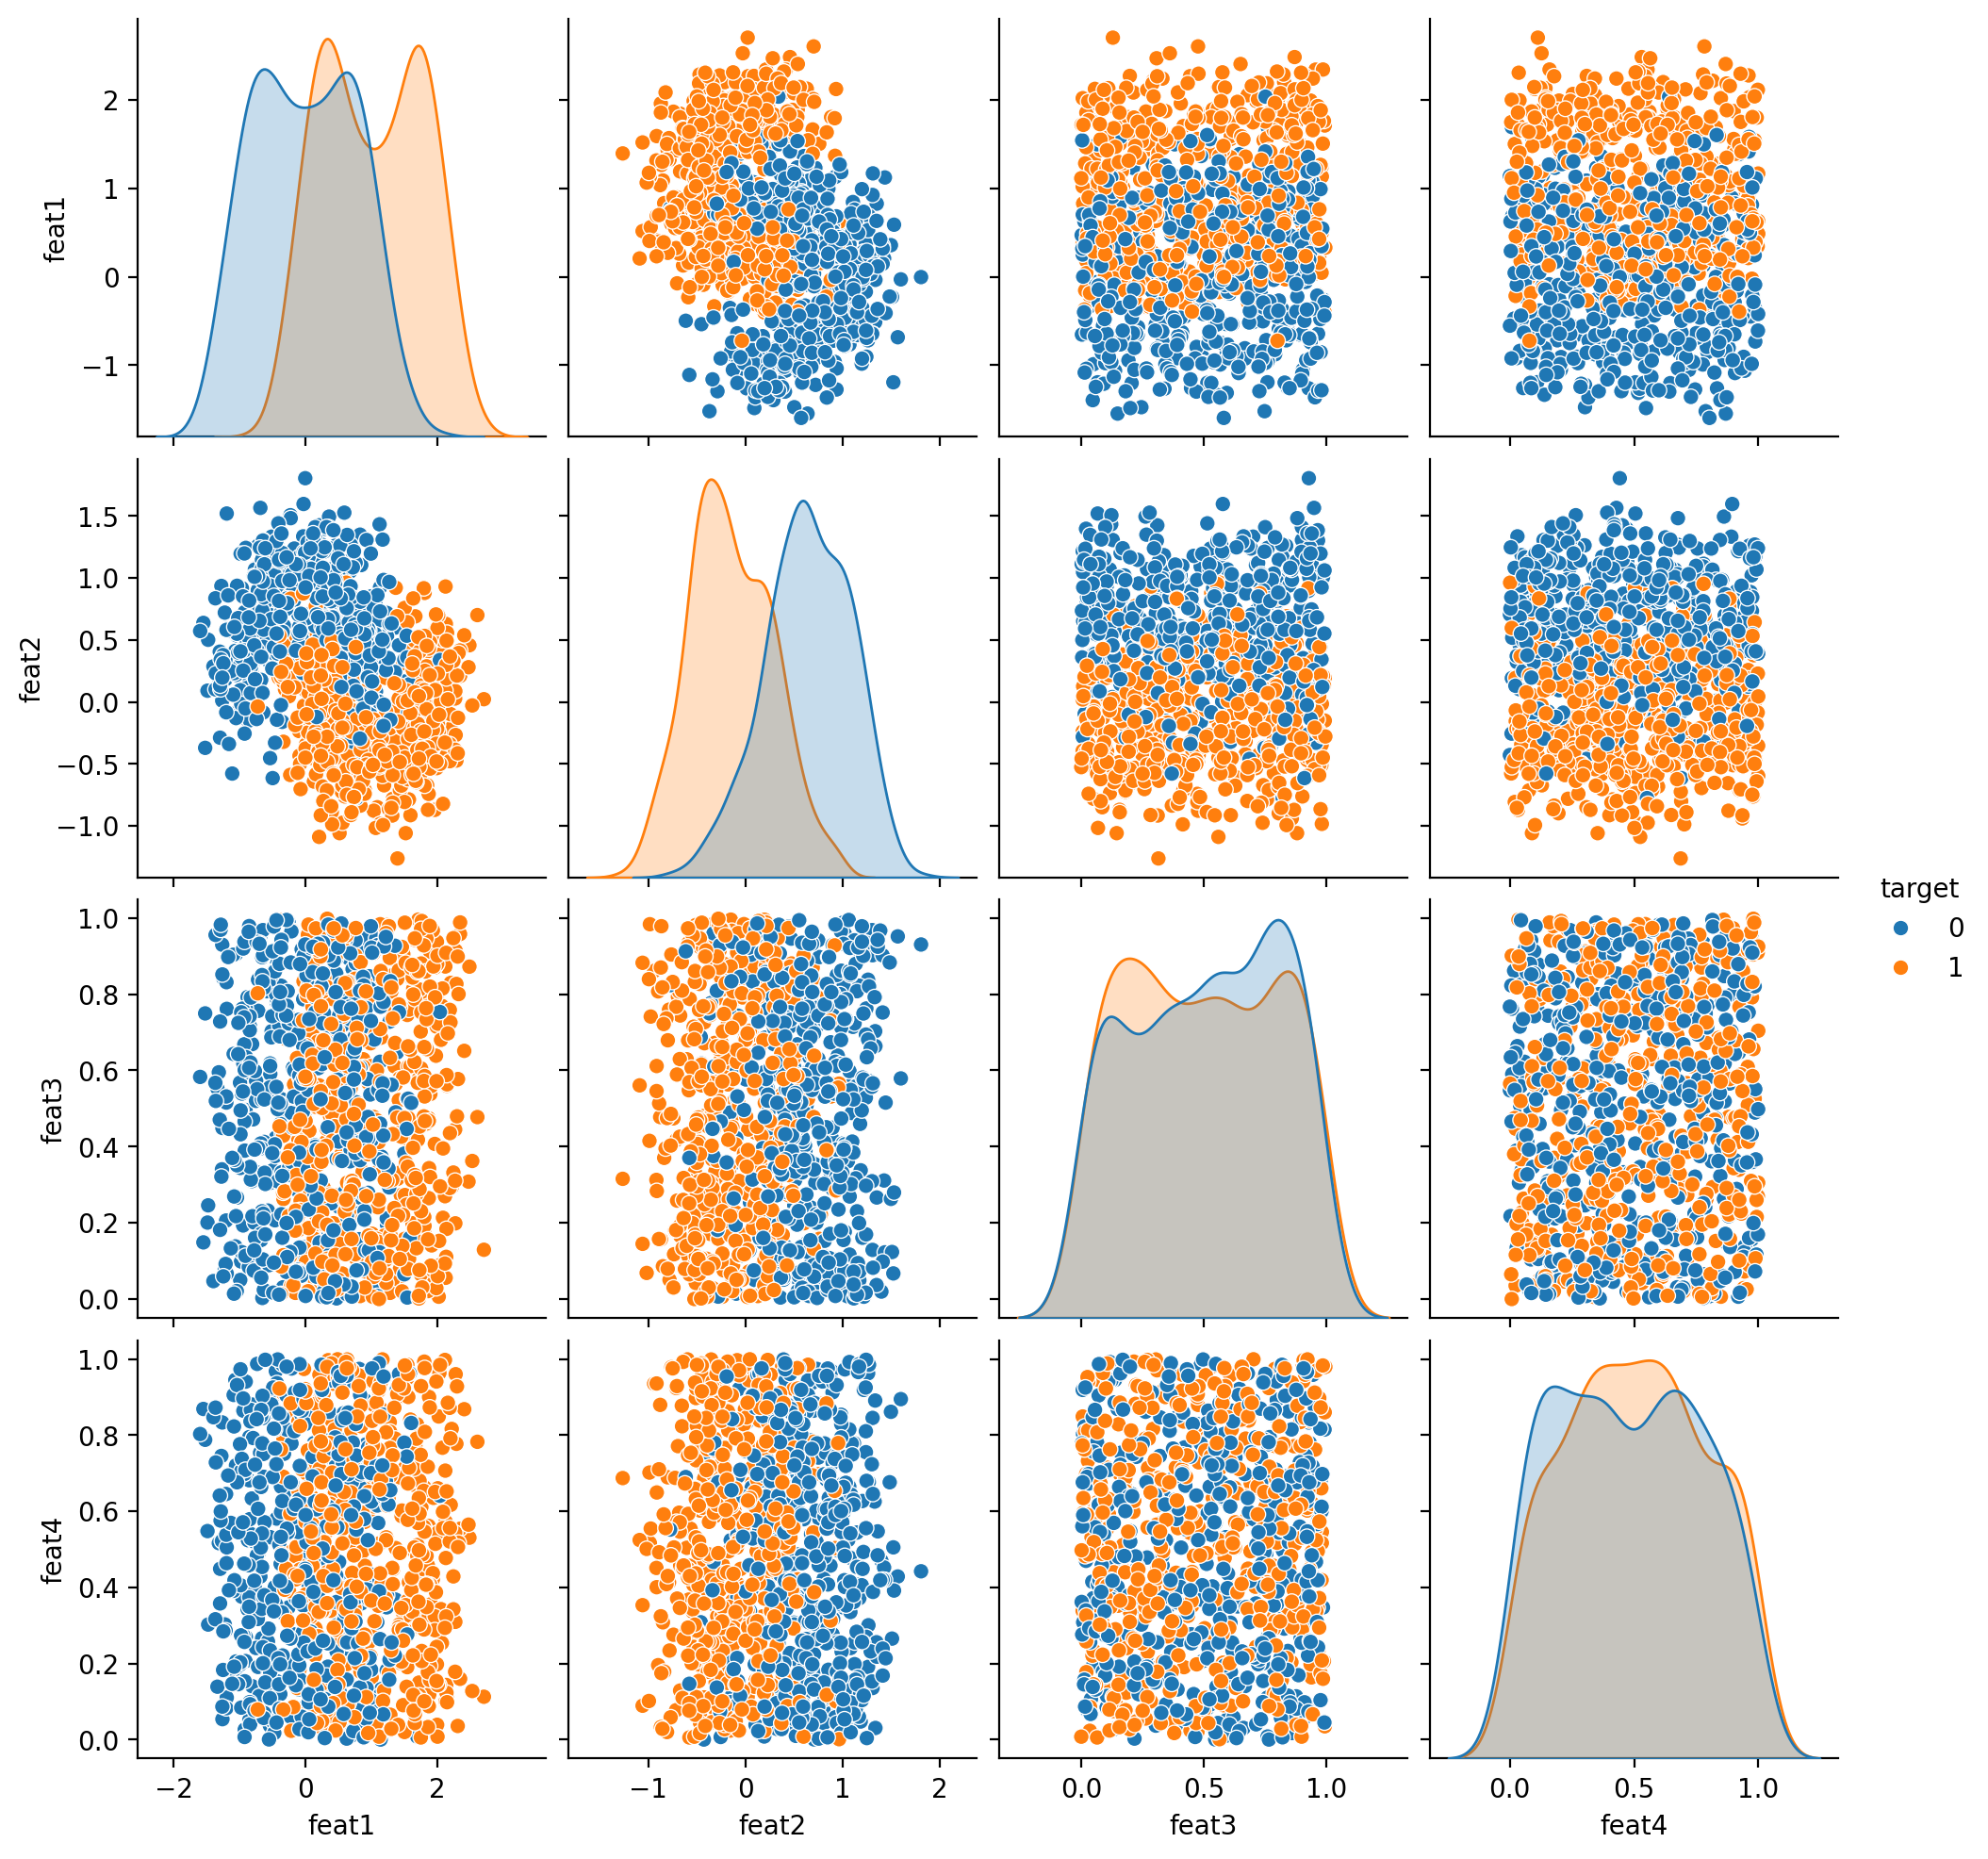

In [3]:
sns.pairplot(df, hue='target')

In [4]:
df.head()

,feat1,feat2,feat3,feat4,target
0,2.129573,0.629904,0.586244,0.477185,1
1,1.888882,0.146257,0.911799,0.303848,1
2,-0.190357,0.383993,0.606396,0.626921,0
3,-0.404416,0.195282,0.995124,0.860015,1
4,0.373012,-0.429716,0.480010,0.728554,1


## Инициализация PyCaret и Spark

In [5]:
from pycaret.classification import setup, compare_models, tune_model, evaluate_model, create_model

from pyspark.sql import SparkSession
from pycaret.parallel import FugueBackend

In [6]:
spark = (
    SparkSession.
    builder.
    appName('pycaret').
    config('spark.driver.memory', '2g').
    config('spark.executor.memory', '2g').
    getOrCreate()
)
    
s = setup(
  data=df, 
  target='target',
  n_jobs=1
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/09 18:34:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,Description,Value
0,Session id,7918
1,Target,target
2,Target type,Binary
3,Original data shape,"(1000, 5)"
4,Transformed data shape,"(1000, 5)"
5,Transformed train set shape,"(700, 5)"
6,Transformed test set shape,"(300, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


## Сравнение доступных алгоритмов

In [7]:
%%time
best = compare_models(
  parallel=FugueBackend(spark)  
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9029,0.9514,0.9171,0.8920,0.9039,0.8057,0.8072,0.218
rf,Random Forest Classifier,0.9014,0.9453,0.9229,0.8854,0.9028,0.8029,0.8054,0.288
knn,K Neighbors Classifier,0.9000,0.9429,0.9171,0.8876,0.9016,0.8000,0.8015,0.032
et,Extra Trees Classifier,0.8986,0.9544,0.9114,0.8890,0.8994,0.7971,0.7989,0.139
lightgbm,Light Gradient Boosting Machine,0.8986,0.9514,0.9029,0.8957,0.8986,0.7971,0.7986,0.212
ada,Ada Boost Classifier,0.8771,0.9381,0.8743,0.8809,0.8762,0.7543,0.7566,0.222
dt,Decision Tree Classifier,0.8629,0.8629,0.8657,0.8619,0.8626,0.7257,0.7278,0.032
lr,Logistic Regression,0.8357,0.9256,0.8314,0.8388,0.8337,0.6714,0.6737,0.045
ridge,Ridge Classifier,0.8343,0.9250,0.8314,0.8367,0.8328,0.6686,0.6706,0.086
lda,Linear Discriminant Analysis,0.8343,0.9247,0.8314,0.8367,0.8328,0.6686,0.6706,0.057


CPU times: user 276 ms, sys: 64.4 ms, total: 341 ms
Wall time: 19 s


## Подбор гиперпараметров

In [8]:
model = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8286,0.9171,0.9143,0.7805,0.8421,0.6571,0.6670
1,0.9000,0.9600,0.8571,0.9375,0.8955,0.8000,0.8030
2,0.8714,0.9469,0.8286,0.9062,0.8657,0.7429,0.7456
3,0.9000,0.9461,0.8857,0.9118,0.8986,0.8000,0.8003
4,0.8857,0.9527,0.9429,0.8462,0.8919,0.7714,0.7765
5,0.9143,0.9592,0.9429,0.8919,0.9167,0.8286,0.8299
6,0.9286,0.9820,0.8571,1.0000,0.9231,0.8571,0.8660
7,0.8857,0.9478,0.8571,0.9091,0.8824,0.7714,0.7727
8,0.9286,0.9780,0.9429,0.9167,0.9296,0.8571,0.8575


In [9]:
tuned_best = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.9388,0.9714,0.7907,0.8718,0.7143,0.7337
1,0.9286,0.9747,0.9143,0.9412,0.9275,0.8571,0.8575
2,0.9000,0.9763,0.8571,0.9375,0.8955,0.8000,0.8030
3,0.9286,0.9596,0.8857,0.9688,0.9254,0.8571,0.8603
4,0.9000,0.9527,0.9714,0.8500,0.9067,0.8000,0.8083
5,0.9714,0.9804,1.0000,0.9459,0.9722,0.9429,0.9444
6,0.9286,0.9776,0.8571,1.0000,0.9231,0.8571,0.8660
7,0.8714,0.9576,0.8571,0.8824,0.8696,0.7429,0.7432
8,0.9429,0.9816,0.9429,0.9429,0.9429,0.8857,0.8857


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [10]:
evaluate_model(tuned_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Прибиваем spark-сессию

In [8]:
spark.stop()